<a href="https://colab.research.google.com/github/InMyDream21/Deep-Learning/blob/main/Tensorflow/zerotomastery/computer_vision/Milestone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

## Check GPU

In [ ]:
!nvidia-smi

Tue Sep  6 11:38:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

In [ ]:
# Download helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-06 11:38:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-06 11:38:56 (92.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper function
from helper_functions import plot_loss_curves, create_tensorboard_callback, compare_historys

## Use TensorFlow Datasets to download data

In [ ]:
# Get tensorflow dataset
import tensorflow_datasets as tfds

In [ ]:
# List all of the available datasets
datasets_list = tfds.list_builders() # Get all available dataset in TFDS
print("food101" in datasets_list) # Is our target dataset in the list of TFDS dataset

True


In [ ]:
# Load in the food101 dataset
(train_data, test_data), ds_info = tfds.load("food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Exploring the Food101 data from TensorFlow Dataset

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like
train_one_sample

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)

In [ ]:
# What does our image tensor look like from TFDS's Food101 look like
image

In [ ]:
# What are the min and max values of image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

### Plot an image from TensorFlow Dataset

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc.).

However, not all data (including data from TFDS) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different size image)
* Not scale (the pixel values are between 0 & 255)

What we know models like:
* Data in Float32 dtype (or for mixed precision `Float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.


In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # Reshape target image
  return tf.cast(image, tf.float32), label # Return (float32_image, label)

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype{image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape},\nDatatype{preprocessed_img.dtype}")

## Batch & Prepare datasets

In [ ]:
import tensorflow as tf
# Map preprcoessing function to training (and parallelize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking throught (finding patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard  callback to log training results (so we can visualize later if need be)
* ModelCheckpoint callback to save oru model's progress after feature extraction

In [ ]:
# Create tensorboard callback (import from helper_function)
from helper_functions import create_tensorboard_callback

# Model checkpoint callback to save a model's progress
checkpoint_path = "model_checkpoint/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_accuracy",
                                                      save_best_only = True,
                                                      vae_weights_only = True)

## Setup mixed precision training

Mixed precision utilized a combination of float32 and float16 data types to speed up model performance.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global data policy to mixed precision

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = 'input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model doesnt u can have a layer like below
# x = preprocessing.Rescaling(1/255)(inputs)
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation(activation = "softmax", dtype = tf.float32, name = 'softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_3 True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer_name` : The human readable name of a particular layer
* `layer.trainable`: is the layer trianable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the datatype a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [ ]:
# Check 
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing thins is:
1. Build a feature extraction model (train a couple output layers with base layers frozen).
2. Fine-tune some of the frozen layers

In [ ]:
# Fit feature extraction model with callbacks
history_101_food_classes = model.fit(train_data,
                                     epochs = 3,
                                     steps_per_epoch = len(train_data),
                                     validation_data = test_data,
                                     validation_steps = int(0.15 * len(test_data)),
                                     callbacks = [create_tensorboard_callback("training_logs",
                                                                              "efficientnetb0_feature_extraction_all_data"),
                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_feature_extraction_all_data/20220122-065048
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 1.8237 - accuracy: 0.5568INFO:tensorflow:Assets written to: model_checkpoint/assets


INFO:tensorflow:Assets written to: model_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 219s 89ms/step - loss: 1.8237 - accuracy: 0.5568 - val_loss: 1.2270 - val_accuracy: 0.6743
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2941 - accuracy: 0.6667INFO:tensorflow:Assets written to: model_checkpoint/assets


INFO:tensorflow:Assets written to: model_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 210s 88ms/step - loss: 1.2942 - accuracy: 0.6667 - val_loss: 1.1295 - val_accuracy: 0.6984
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1435 - accuracy: 0.7015INFO:tensorflow:Assets written to: model_checkpoint/assets


INFO:tensorflow:Assets written to: model_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 215s 90ms/step - loss: 1.1435 - accuracy: 0.7015 - val_loss: 1.0894 - val_accuracy: 0.7127


In [ ]:
# Evaluate model on the whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 49s 62ms/step - loss: 1.0872 - accuracy: 0.7063


[1.0872379541397095, 0.7063366174697876]

# Our turn

In [ ]:
# Saving the model
save_dir = "feature_extraction_model"
model.save(save_dir)

INFO:tensorflow:Assets written to: feature_extraction_model/assets


INFO:tensorflow:Assets written to: feature_extraction_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
import os
# Saving the model to google drive
save_dir = "drive/MyDrive/tensorflow_course/all_classes_feature_extract/"
os.makedirs(save_dir)

# Save model
model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/all_classes_feature_extract/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/all_classes_feature_extract/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
loaded_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Evaluate the loaded model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 51s 64ms/step - loss: 1.0872 - accuracy: 0.7063


[1.0872381925582886, 0.7063366174697876]

In [ ]:
import numpy as np
np.isclose(loaded_model_results, results_feature_extract_model)

array([ True,  True])

In [ ]:
for layer in loaded_model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 True float32 <Policy "float32">
rescaling_3 False float32 <Policy "mixed_float16">
normalization_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False 

## Prepare model layers for fine-tuning

In [ ]:
# Download saved model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-01-22 07:28:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.96.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  37.8MB/s    in 0.4s    

2022-01-22 07:28:28 (37.8 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the saved model
!mkdir downloaded_gs_model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded gs model
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of the downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Evaluate on the test data
loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 52s 65ms/step - loss: 1.0881 - accuracy: 0.7065


[1.0881284475326538, 0.7064950466156006]

In [ ]:
# Set all of the layers unfrozen
for layer in loaded_gs_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True


In [ ]:
for layer in loaded_gs_model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_1 True <Policy "float32">
rescaling True <Policy "mixed_float16">
normalization True <Policy "float32">
stem_conv_pad True <Policy "mixed_float16">
stem_conv True <Policy "mixed_float16">
stem_bn True <Policy "mixed_float16">
stem_activation True <Policy "mixed_float16">
block1a_dwconv True <Policy "mixed_float16">
block1a_bn True <Policy "mixed_float16">
block1a_activation True <Policy "mixed_float16">
block1a_se_squeeze True <Policy "mixed_float16">
block1a_se_reshape True <Policy "mixed_float16">
block1a_se_reduce True <Policy "mixed_float16">
block1a_se_expand True <Policy "mixed_float16">
block1a_se_excite True <Policy "mixed_float16">
block1a_project_conv True <Policy "mixed_float16">
block1a_project_bn True <Policy "mixed_float16">
block2a_expand_conv True <Policy "mixed_float16">
block2a_expand_bn True <Policy "mixed_float16">
block2a_expand_activation True <Policy "mixed_float16">
block2a_dwconv_pad True <Policy "mixed_float16">
block2a_dwconv True <Policy "mixed_float16

In [ ]:
# Setup earlystopping callback to stop if model's vall_loss not improving after 3 epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience = 3)

# Create modelcheckpoint callback 
# Save best model monitoring the val_loss
checkpoint_path = "fine_tune_checkpoints/"
modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                              save_best_only = True)

In [ ]:
# Compile the model
loaded_gs_model.compile(loss = "sparse_categorical_crossentropy",
                        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                        metrics = ["accuracy"])

In [ ]:
# Fit the model
loaded_gs_model.fit(train_data,
                    epochs = 100,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.15 * len(test_data)),
                    callbacks = [create_tensorboard_callback("training_logs",
                                                             "efficientnetb0_fine-tune"),
                                 early_stop_callback,
                                 modelcheckpoint_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_fine-tune/20220122-074609
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 0.9207 - accuracy: 0.7535INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 453s 185ms/step - loss: 0.9207 - accuracy: 0.7535 - val_loss: 0.7791 - val_accuracy: 0.7836


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.8411INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 384s 161ms/step - loss: 0.5766 - accuracy: 0.8411 - val_loss: 0.7787 - val_accuracy: 0.7858
Epoch 3/100
2368/2368 [==============================] - 339s 143ms/step - loss: 0.3319 - accuracy: 0.9055 - val_loss: 0.8626 - val_accuracy: 0.7884
Epoch 4/100
2368/2368 [==============================] - 336s 141ms/step - loss: 0.1764 - accuracy: 0.9476 - val_loss: 1.0022 - val_accuracy: 0.7762
Epoch 5/100
2368/2368 [==============================] - 334s 140ms/step - loss: 0.1044 - accuracy: 0.9685 - val_loss: 1.0134 - val_accuracy: 0.7889


In [ ]:
# Save the model
save_dir = "/content/drive/MyDrive/tensorflow_course/milestone_project_fine-tune"
os.makedirs(save_dir)

loaded_gs_model.save(save_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/milestone_project_fine-tune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/milestone_project_fine-tune/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Evaluate the model
loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 52s 66ms/step - loss: 1.0367 - accuracy: 0.7820


[1.0367156267166138, 0.7819802165031433]

In [ ]:
!tensorboard dev upload --logdir ./training_logs/ \
  --name "EfficientNetB0 Feature Extraction vs Fine-tuning all dataset" \
  --description "Milestone project 1 on Food101 Dataset with EfficientNetB0 architecture feature extraction and fine-tuning" \
  --one_shot

The link of the TensorBoard can be found here:
https://tensorboard.dev/experiment/t7z4z7GtQvS6QK5izeUjeg/

## Load in model from Google Drive

In [ ]:
import tensorflow as tf

load_dir = "/content/drive/MyDrive/tensorflow_course/milestone_project_fine-tune"
loaded_gd_model = tf.keras.models.load_model(load_dir)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
loaded_gd_model.evaluate(test_data)

790/790 [==============================] - 60s 63ms/step - loss: 1.0367 - accuracy: 0.7820


[1.0367153882980347, 0.7819802165031433]

## Plotting the predictions

In [ ]:
for images, labels in test_data.take(1):
  for i in range(32):
    pred = loaded_gd_model.predict(tf.expand_dims(images[i], axis = 0))
    pred_prob = pred.max()
    pred_class = class_names[pred.argmax()]
    actual_class = class_names[labels[i]]
    print(f"Actual: {actual_class}, predicted: {pred_class}\n prob: {pred_prob:.2f}")

Actual: red_velvet_cake, predicted: red_velvet_cake
 prob: 0.99
Actual: cheesecake, predicted: cheesecake
 prob: 0.92
Actual: lobster_bisque, predicted: lobster_bisque
 prob: 1.00
Actual: dumplings, predicted: creme_brulee
 prob: 0.76
Actual: falafel, predicted: falafel
 prob: 1.00
Actual: strawberry_shortcake, predicted: strawberry_shortcake
 prob: 0.98
Actual: greek_salad, predicted: greek_salad
 prob: 1.00
Actual: apple_pie, predicted: waffles
 prob: 0.82
Actual: mussels, predicted: mussels
 prob: 1.00
Actual: cup_cakes, predicted: cup_cakes
 prob: 1.00
Actual: huevos_rancheros, predicted: breakfast_burrito
 prob: 1.00
Actual: filet_mignon, predicted: steak
 prob: 0.64
Actual: scallops, predicted: scallops
 prob: 0.63
Actual: mussels, predicted: mussels
 prob: 1.00
Actual: miso_soup, predicted: miso_soup
 prob: 1.00
Actual: crab_cakes, predicted: tuna_tartare
 prob: 0.65
Actual: beef_carpaccio, predicted: beef_carpaccio
 prob: 0.96
Actual: panna_cotta, predicted: panna_cotta
 prob: 

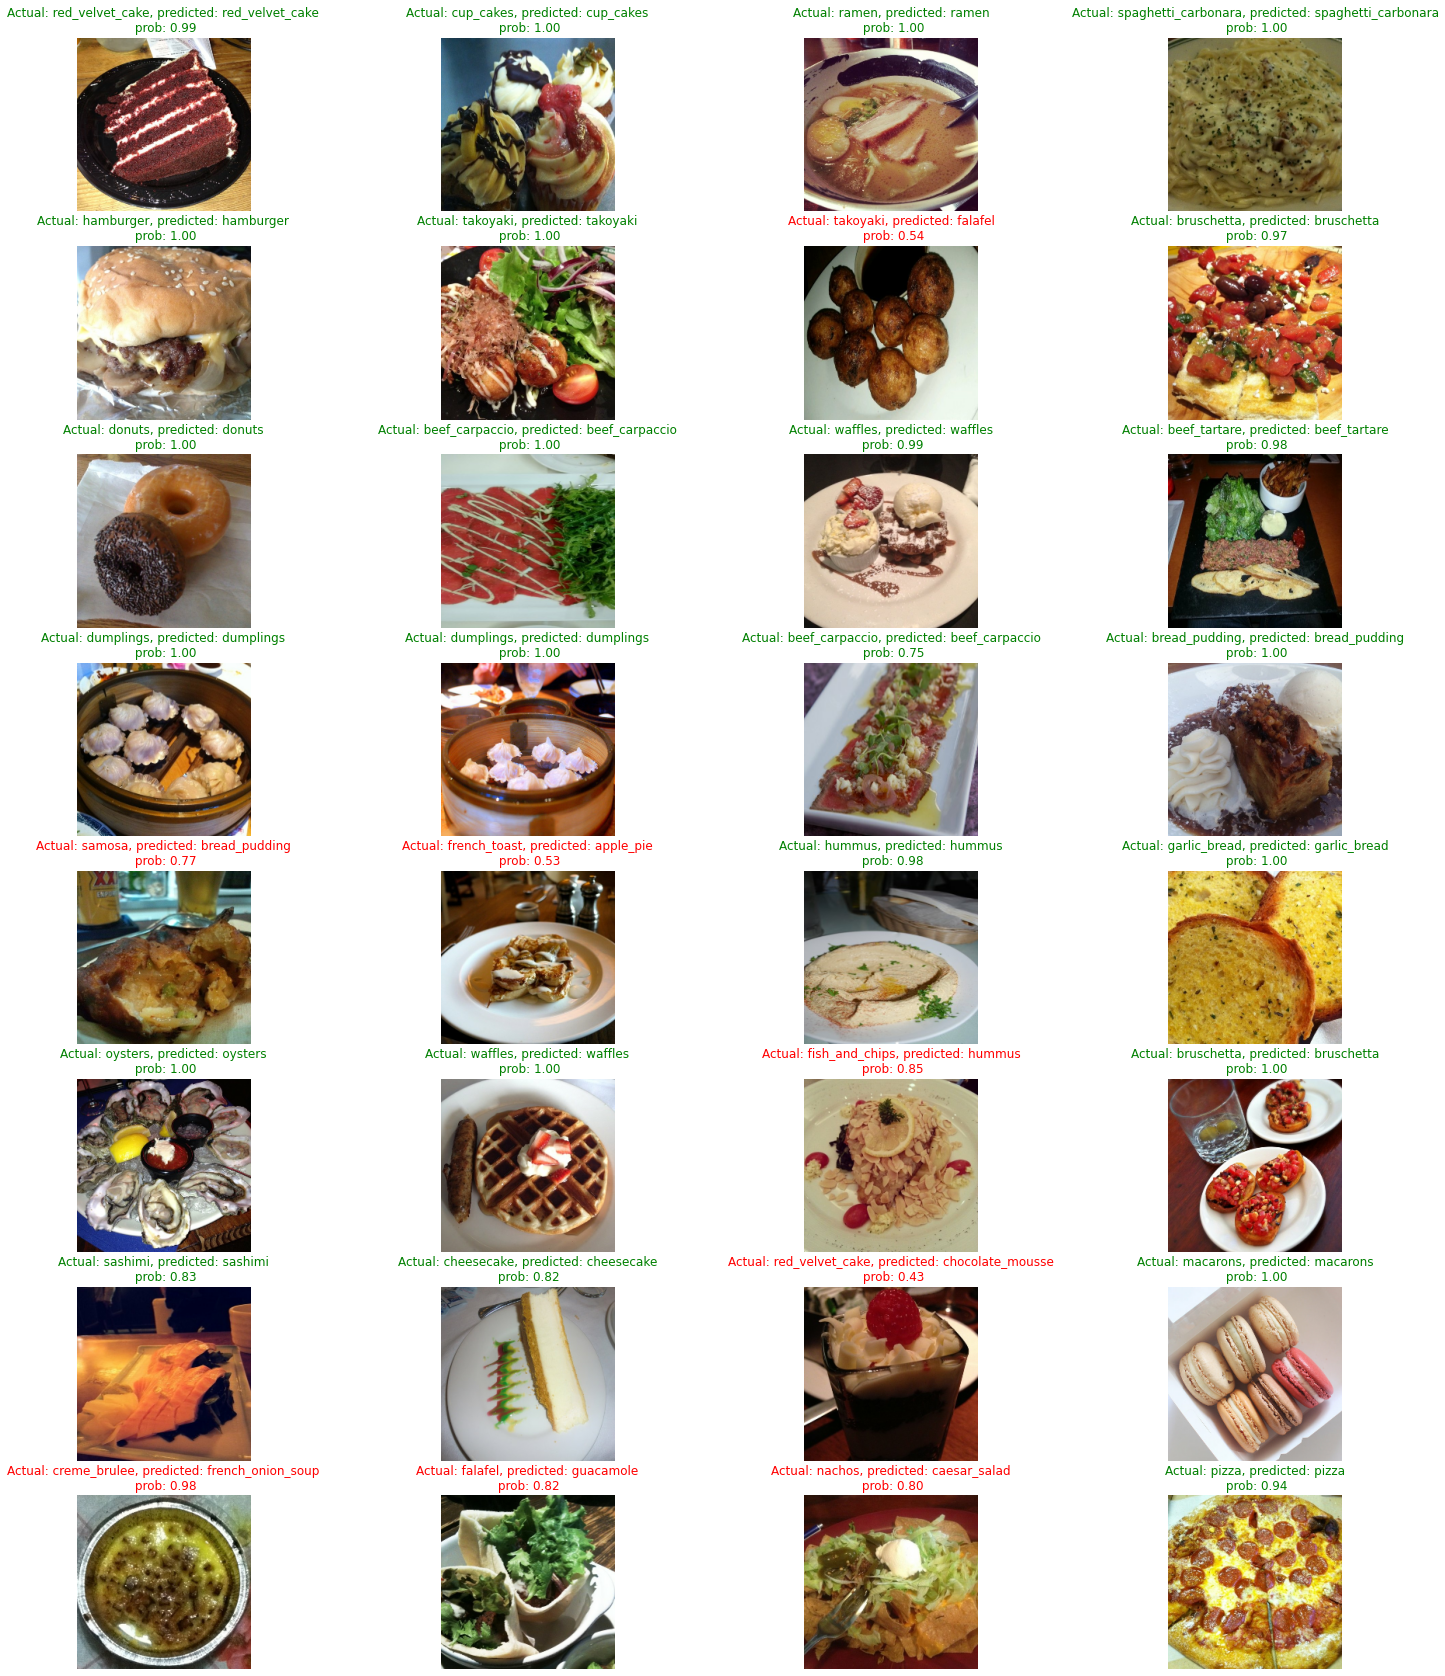

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (25, 30))
for images, labels in test_data.take(1):
  for i in range(32): # Batch size
    pred = loaded_gd_model.predict(tf.expand_dims(images[i], axis = 0))
    pred_prob = pred.max()
    pred_class = class_names[pred.argmax()]
    actual_class = class_names[labels[i]]
    plt.subplot(8, 4, i + 1)
    plt.imshow(images[i]/255)
    if actual_class == pred_class:
      title_color = "g"
    else:
      title_color = "r"
    plt.title(f"Actual: {actual_class}, predicted: {pred_class}\n prob: {pred_prob:.2f}", c = title_color)
    plt.axis(False);

## Making a Confusion matrix

In [ ]:
preds_probs = loaded_gd_model.predict(test_data, verbose = 1)

790/790 [==============================] - 51s 63ms/step


In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
preds_probs[0].argmax()

83

In [ ]:
# Whats the shape of our predictions
preds_probs.shape

(25250, 101)

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis = 1)

pred_classes

array([83, 16, 60, ..., 46, 22, 88])

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())

y_labels[:10]

[57, 48, 79, 44, 81, 43, 27, 47, 46, 22]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels verically) ###
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

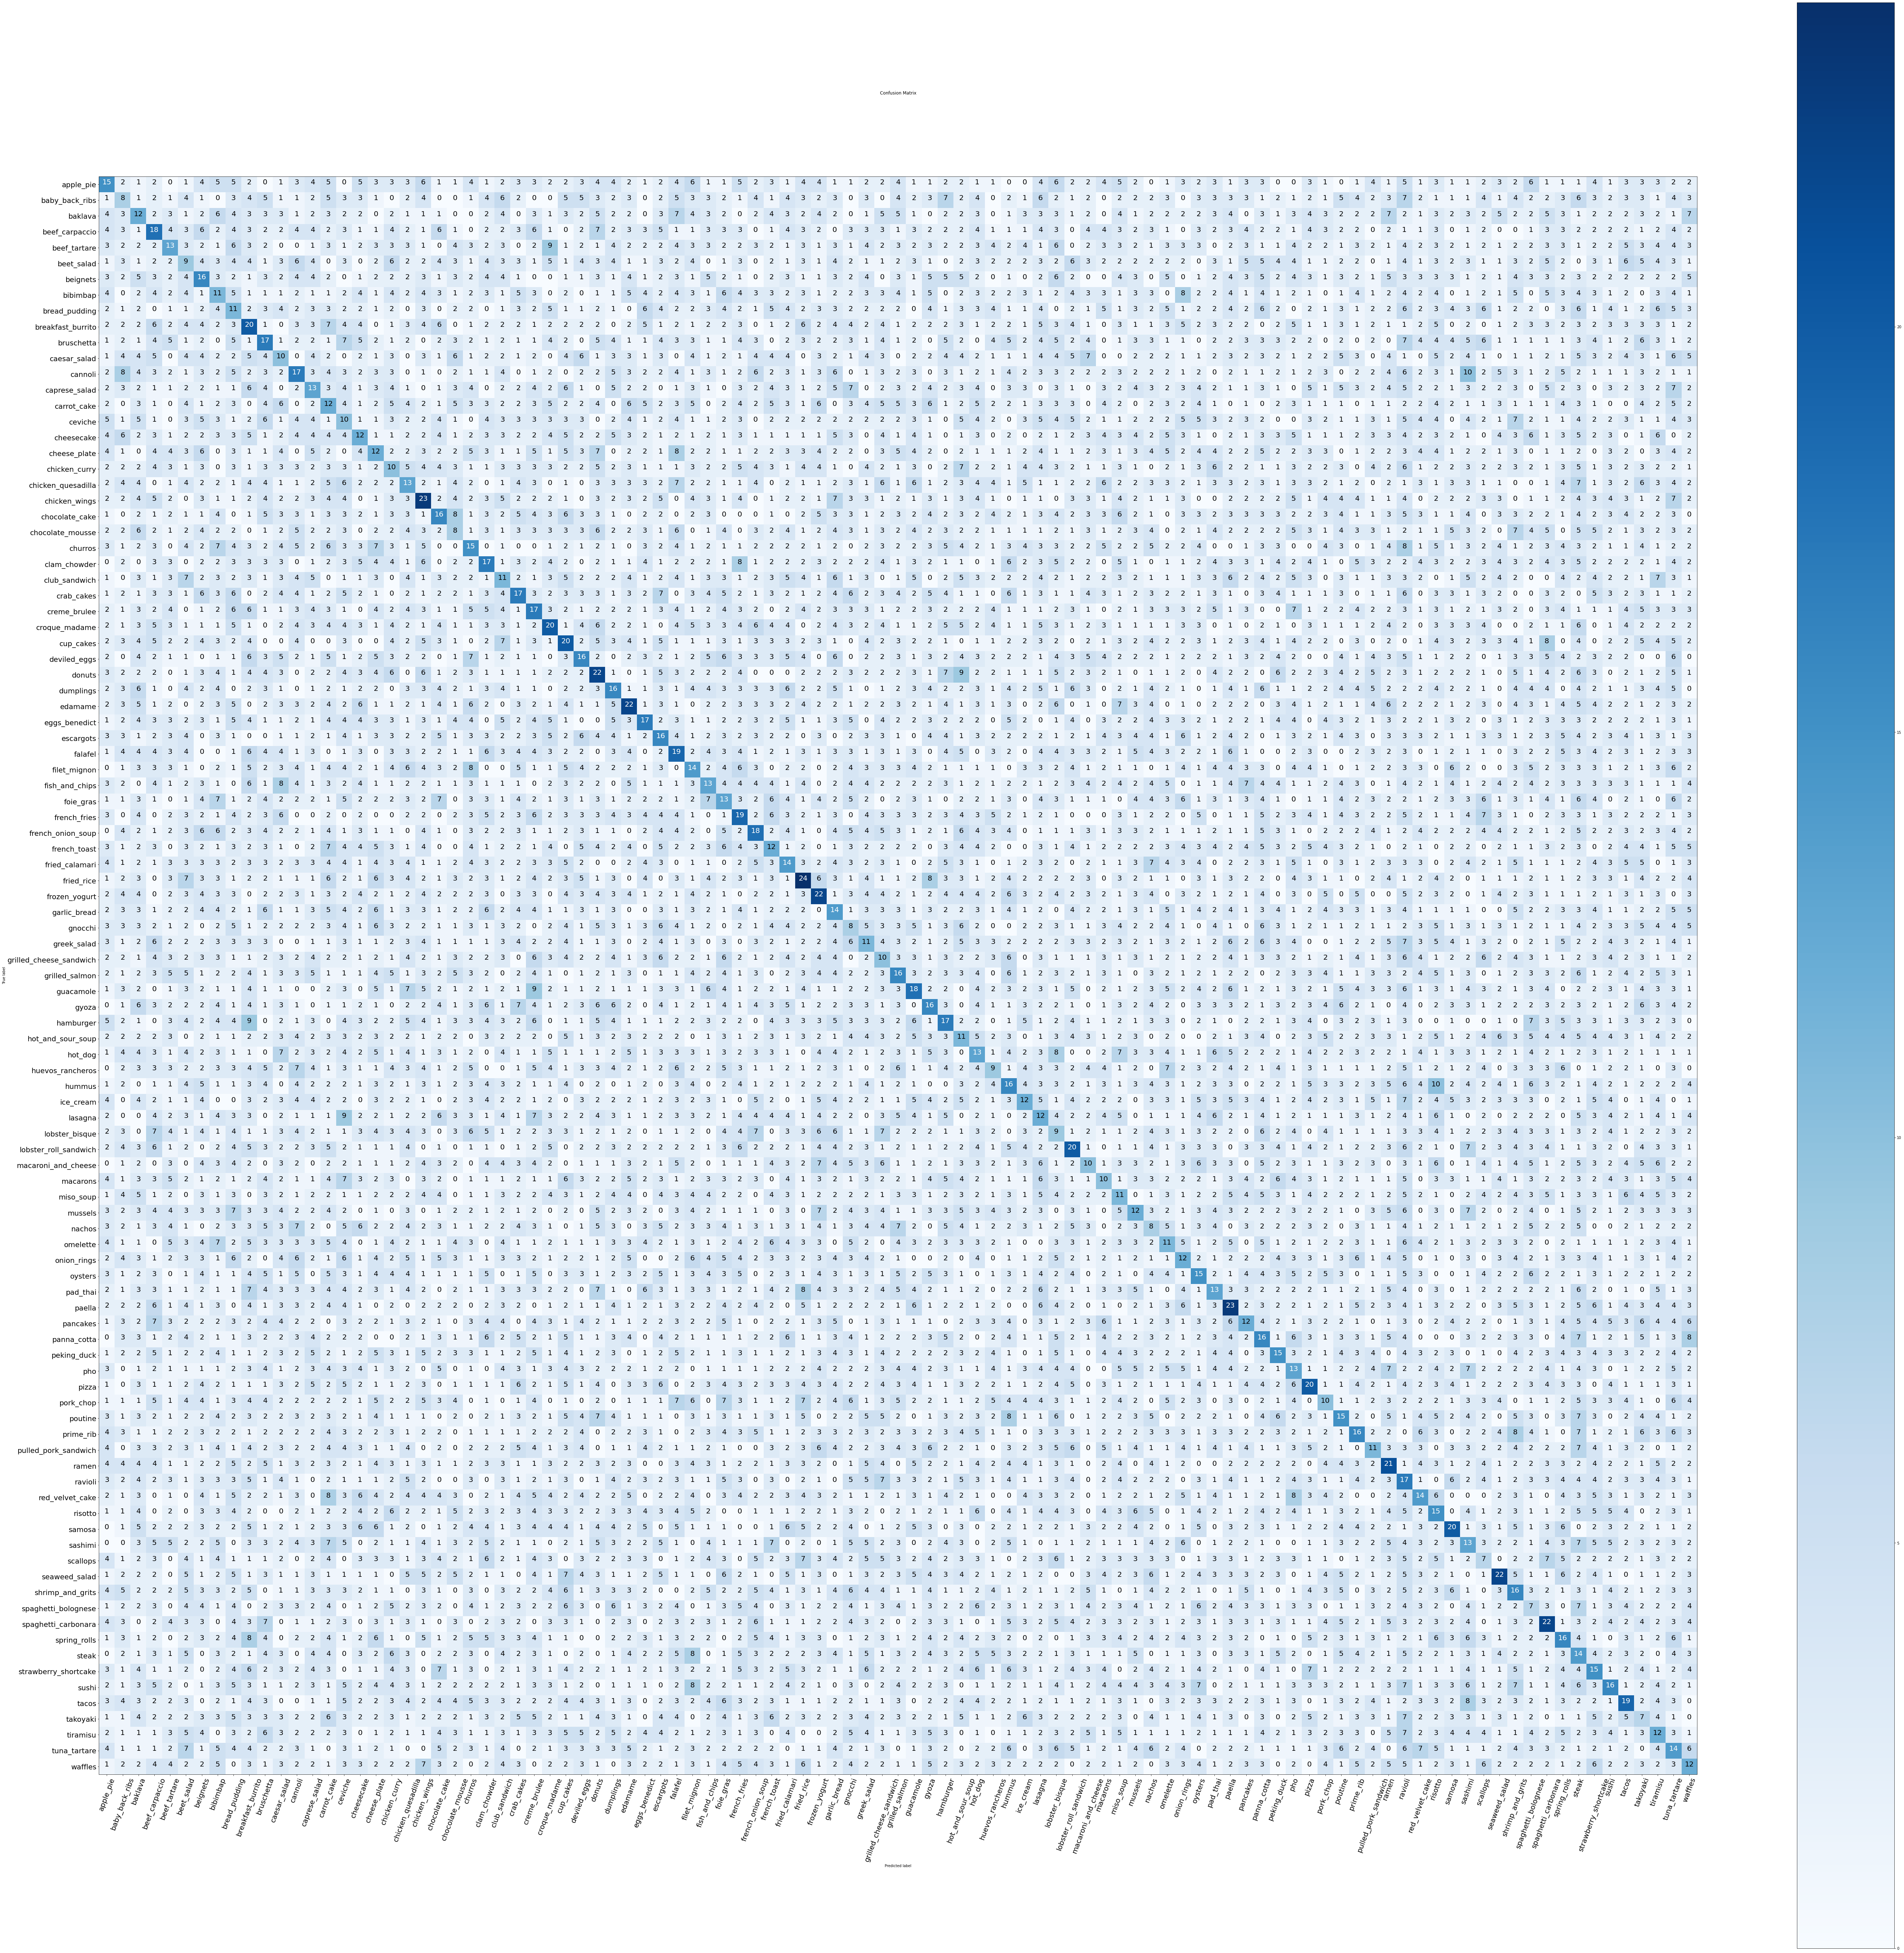

In [ ]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100, 100),
                      text_size = 20,
                      savefig = True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.07      0.06      0.06       250
           1       0.04      0.03      0.04       250
           2       0.05      0.05      0.05       250
           3       0.07      0.07      0.07       250
           4       0.06      0.05      0.06       250
           5       0.04      0.04      0.04       250
           6       0.06      0.06      0.06       250
           7       0.04      0.04      0.04       250
           8       0.04      0.04      0.04       250
           9       0.07      0.08      0.07       250
          10       0.06      0.07      0.07       250
          11       0.04      0.04      0.04       250
          12       0.07      0.07      0.07       250
          13       0.05      0.05      0.05       250
          14       0.04      0.05      0.04       250
          15       0.03      0.04      0.04       250
          16       0.06      0.05      0.05       250
          17       0.05    